In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Bidirectional,
    Dropout,
    Flatten,
    Dense,
    Input,
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

from utils import load_dataset, train
from einops import rearrange

<IPython.core.display.Javascript object>

[Reference](https://github.com/uci-cbcl/DanQ/blob/master/DanQ_train.py) 

In [2]:
from tensorflow.config import list_physical_devices

print(list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<IPython.core.display.Javascript object>

In [3]:
clear_session()
model = Sequential(
    [
        Input(shape=(1000, 4)),
        Conv1D(320, kernel_size=26, activation="relu"),
        MaxPooling1D(pool_size=13, strides=13),
        Dropout(0.2),
        Bidirectional(LSTM(2, return_sequences=True)),
        Dropout(0.5),
        Flatten(),
        Dense(150 * 320, activation="relu"),
        Dense(1, activation="relu"),
    ]
)

<IPython.core.display.Javascript object>

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 975, 320)          33600     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 320)           0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 320)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 75, 4)             5168      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 4)             0         
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 48000)             1

<IPython.core.display.Javascript object>

In [5]:
es = EarlyStopping(monitor="val_loss", patience=10)
optimizer = Adam(lr=1e-3)

epochs = 1000
validation_freq = 1

<IPython.core.display.Javascript object>

Epoch 1/1000
1000/1000 [==============================] - 38s 36ms/step - loss: 1.6600 - acc: 0.8858 - val_loss: 2.3789 - val_acc: 0.8440
Epoch 2/1000
1000/1000 [==============================] - 35s 35ms/step - loss: 1.6309 - acc: 0.8931 - val_loss: 2.3789 - val_acc: 0.8440
Epoch 3/1000
1000/1000 [==============================] - 35s 35ms/step - loss: 1.6744 - acc: 0.8902 - val_loss: 2.3789 - val_acc: 0.8440 1.6766 -
Epoch 4/1000
1000/1000 [==============================] - 35s 35ms/step - loss: 1.6309 - acc: 0.8931 - val_loss: 2.3789 - val_acc: 0.8440loss: 1.6261 - acc: - ET - ETA: 3s - loss: - ETA: 1s - l
Epoch 5/1000
1000/1000 [==============================] - 35s 35ms/step - loss: 1.6408 - acc: 0.8924 - val_loss: 2.3789 - val_acc: 0.8440
Epoch 6/1000
1000/1000 [==============================] - 35s 35ms/step - loss: 1.6290 - acc: 0.8932 - val_loss: 2.3789 - val_acc: 0.8440
Epoch 7/1000
1000/1000 [==============================] - 35s 35ms/step - loss: 1.6561 - acc: 0.8914 - val_

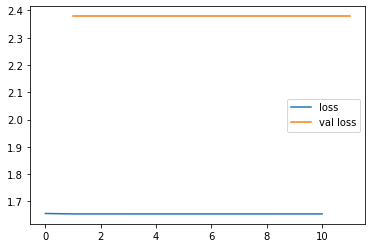

Training time: 6.49 minutes


<IPython.core.display.Javascript object>

In [6]:
X_train, y_train, X_test, y_test = load_dataset(
    file=f"m0",
    directory="/home/victor/Documents/datasets/",
    labels="binlabels",
    download=False,
)
X_train = rearrange(X_train, "w h c -> w c h")
X_test = rearrange(X_test, "w h c -> w c h")

model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"],
)

model = train(
    dataset=(X_train, y_train, X_test, y_test),
    model=model,
    epochs=epochs,
    verbose=1,
    validation_freq=validation_freq,
    callbacks=[es],
    batch_size=100,
)

In [7]:
model.save("../model_saves/DanQ.h5")

<IPython.core.display.Javascript object>